# Uranium-oxygen bond length analysis

This notebook is an example of the use of the code **retrieve_MPDS.py** in retrieving crystalline structures from MPDS database. Let's say we want to study the chemical bond of uranium and oxygen. What is the length or lengths of this bond the most frequently reported in the literature? MPDS contains more than 2500 crystalline structures with uranium and oxygen, so why shouldn't we perform a quick data investigation to answer this question.
    

In [ ]:
import pandas as pd
from matminer.data_retrieval.retrieve_MPDS import MPDSDataRetrieval
    

Here we use a naive brute-force approach to calculate bond lengths between particular atom types in a crystalline environment. Obviously, we are interested in neighboring atoms only, so we do not consider interatomic distances more than, let's say, 4 Angstrom. We then represent a crystalline structure with the **ase**'s `Atoms` class and calculate distances using its `get_distance` method. Note rounding of distances marked by comment `NB` in the code:
    

In [ ]:
def calculate_lengths(ase_obj, elA, elB, limit=4):
    assert elA != elB
    lengths = []
    for n, atom in enumerate(ase_obj):
        if atom.symbol == elA:
            for m, neighbor in enumerate(ase_obj):
                if neighbor.symbol == elB:
                    dist = round(ase_obj.get_distance(n, m), 2) # NB occurrence <-> rounding
                    if dist < limit:
                        lengths.append(dist)
    return lengths
    

Note that the crystalline structures are not retrieved from MPDS by default, so we need to specify additional five fields:
* `cell_abc`
* `sg_n`
* `setting`
* `basis_noneq`
* `els_noneq`

On top of that, we also obtain crystalline `phase_id`s, MPDS entry numbers, and chemical formulae. Note that `get_data` API client method returns a usual Python list, whereas `get_dataframe` API client method returns a Pandas dataframe. We use the former below:
    

In [ ]:
client = MPDSDataRetrieval()

answer = client.get_data(
    {"elements": "U-O", "props": "atomic structure"},
    fields={'S':['phase_id', 'entry', 'chemical_formula', 'cell_abc', 'sg_n', 'setting', 'basis_noneq', 'els_noneq']}
)
    

`MPDSDataRetrieval.compile_crystal` API client method helps us to handle the crystalline structure in the **ase**'s `Atoms` flavour. Of course, any other library (_e.g._ Pymatgen) can be used instead. We then call `calculate_lengths` function defined earlier.
    

In [ ]:
lengths = []

for item in answer:
    crystal = MPDSDataRetrieval.compile_crystal(item)
    if not crystal: continue
    lengths.extend( calculate_lengths(crystal, 'U', 'O') )
    

That runs a little bit slow (about five minutes), since **ase**'s `Atoms` are expectedly not performing very well on dozens of thousands of bond length calculations. We may want to employ a C-extension here, but this is outside the scope of this exercise. Anyway now we have a flat list `lengths`. Let's convert it into a Pandas Dataframe and find which `U-O` distances occur more often than the others.
    

In [ ]:
dfrm = pd.DataFrame(sorted(lengths), columns=['length'])
dfrm['occurrence'] = dfrm.groupby('length')['length'].transform('count')
dfrm.drop_duplicates('length', inplace=True)
    

What did we do here? We calculated the numbers of occurrences (counts) of each particular `U-O` length and then augmented our dataframe with this new information, creating a new column `occurrence`. Now it's up to the reader to visualize the result (this is a matter of taste). Below is a bar chart rendered using `Plotly` and `D3` JavaScript libraries.
    

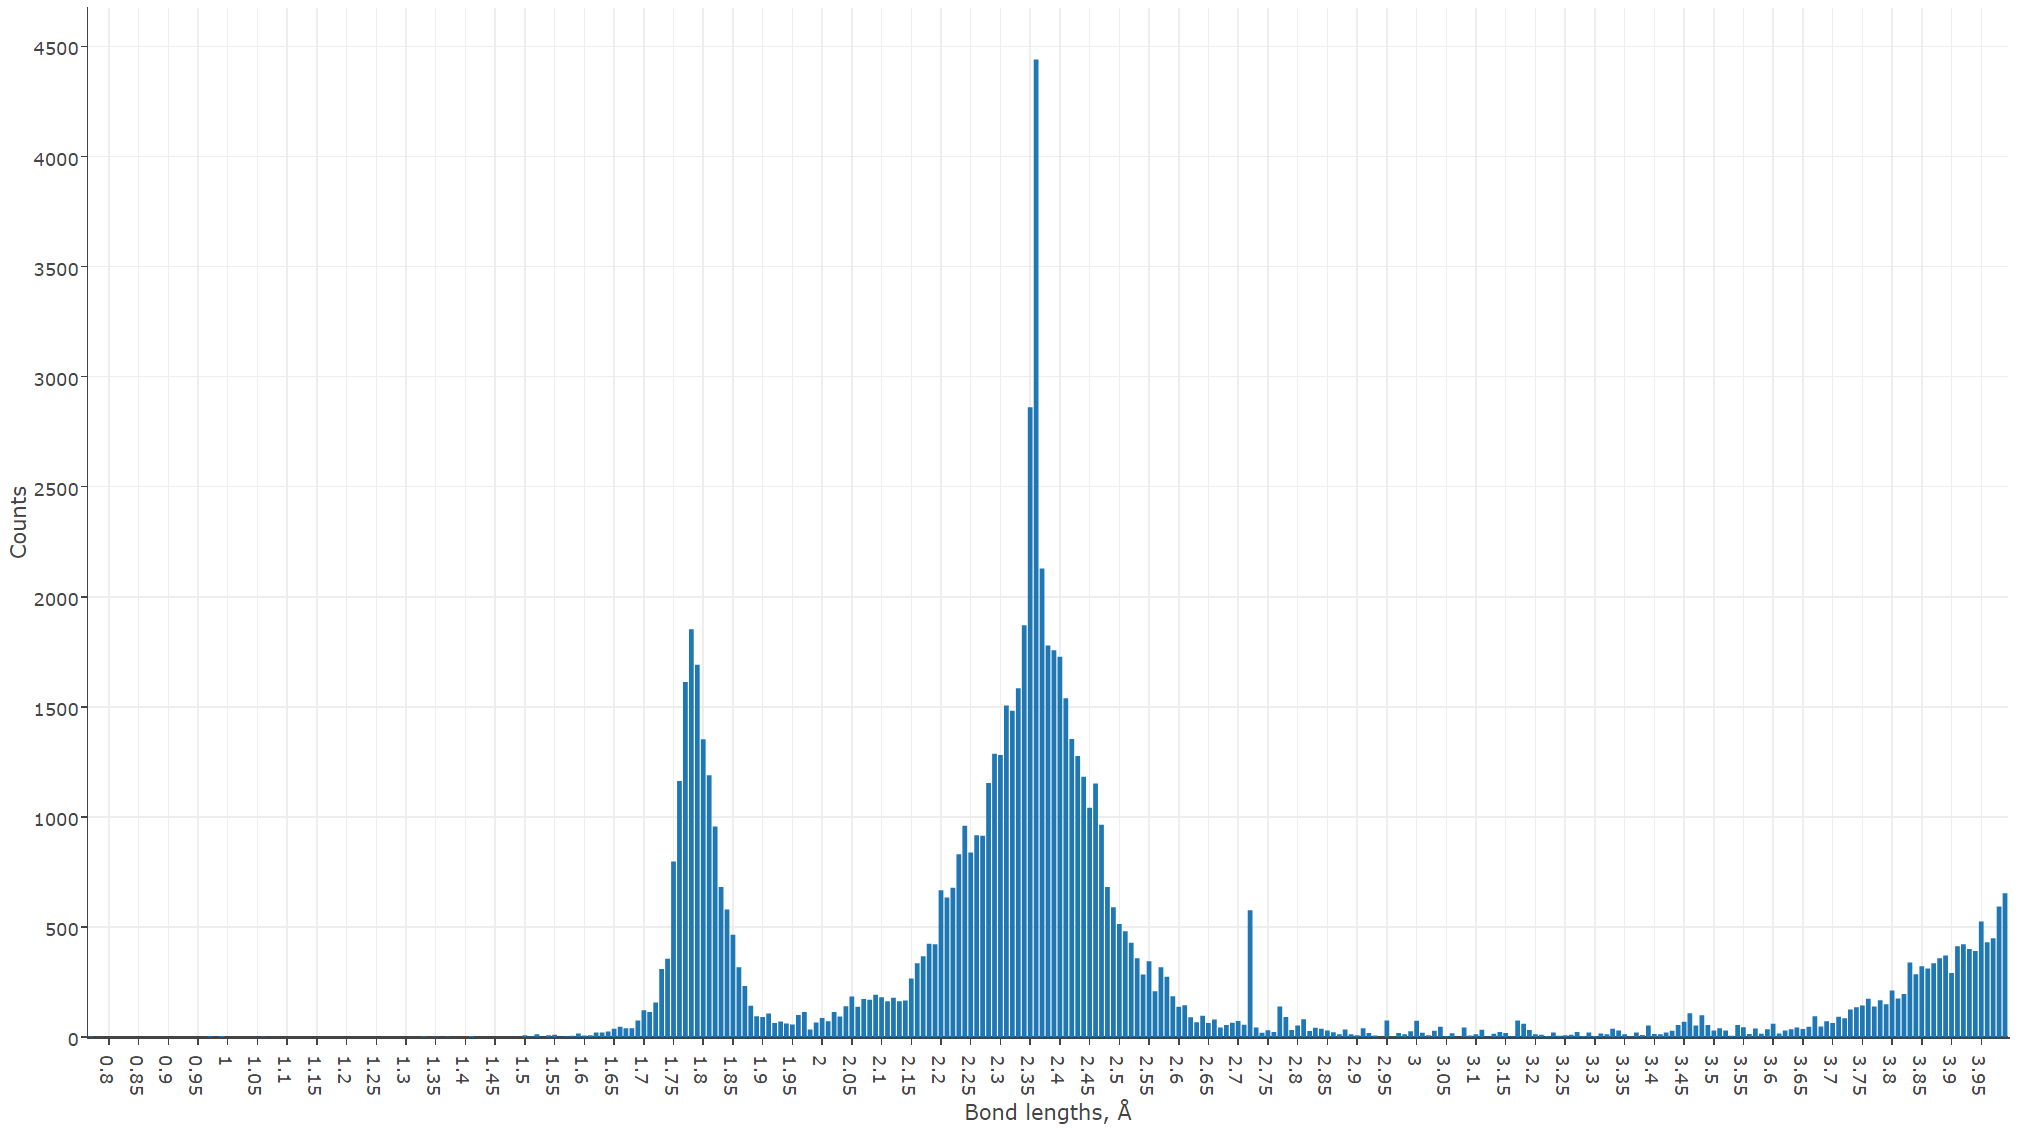
    

We can see now that the most frequent bond lengths between the neighboring uranium and oxygen atoms are 1.78 and 2.35 Angstrom. This excellently agrees with the well-known study of Burns _et al._ [[1]](http://canmin.geoscienceworld.org/content/35/6/1551), done in 1997. However, Burns considered only 105 structures, and we did more than 2500, confirming very well although his findings on the uranyl ion geometry.
    